Yule Process: 

It's a pure-birth process which is a Poisson process for simulation of the population at time $t$, $X(t)$.

It's a continuous-time Markov chain with transition probabilities:

\begin{equation}
\begin{split}
&P(X(t+\Delta t)=n+1  | X(t)=n)= \nu_n\,\Delta t\\
&P(X(t+\Delta t)=n  | X(t)=n)= 1-\nu_n\,\Delta t
\end{split}
\end{equation}

We call $\nu_n$ as the rate of the change at state $n$. For a special case we have $\nu_n= b\,n^{d}$ for some parameter $b$. If $d=1$,
then we have the linear growth. It can be proved that if $\Sigma\, 1/\nu_n < \infty$, then the population size explodes in a finte time; in other words, we will have infintely many jumps in a finte time. Therefore for the special case where, $\nu_n= b\,n^{d}$, we have an explosive Markov chain if $d>1$.

Simulation of Yule process can be done using two different techniques: Sampling of time increments and tau-leaping method. In the the first method, we use the fact that waiting time (sojurn time) until the next jump in the population, when the current population is $n$, is exponentially distributed with mean $1/\nu_{n}$ and hence we can sample the time incerements from these exponential distributions. 

In the following cells, I have simulated one special case of Yule process, where $\nu_n= b\,n^{d}$ with inital population $X_{0}=1$. I have simulated until a max population $N=2000$ and with 3 different degrees, $d$, for the rate of the change to show the explosive Markov chains for $d>1$.

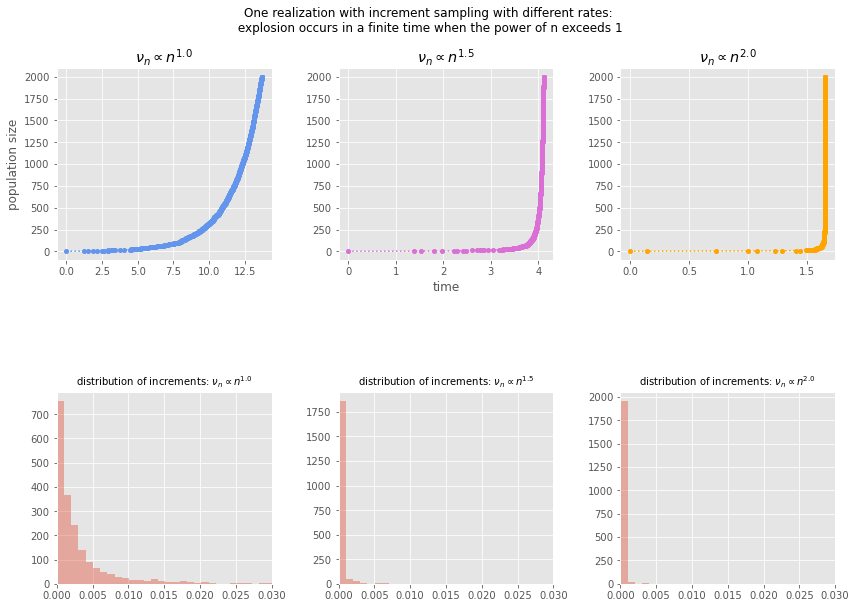

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
import scipy.misc
import scipy.special
from matplotlib.lines import Line2D 
import seaborn as sns
from cycler import cycler

plt.style.use('ggplot')
np.random.seed(0)
  
def increment_sampling(b, N, P0, d, n_sim):
    
    """
    b = birth_rate
    N = max population 
    P0 = initial population 
    n_sim = number of simulations
    d = degree of population growth. 
    """    
    s = np.zeros((n_sim, N))  # sojurn times
    X1 = np.zeros((n_sim, N)) # population matrix
    inc = np.zeros((n_sim,N))
    X1[:,0] = P0

    for j in range(n_sim):
        for i in range(N-1):
            U = np.random.uniform(0,1)
            h = - np.log(U)/(b*X1[j,i]**d)  # time incerements
            inc[j,i] = h
            s[j,i+1] = s[j,i] + h
            X1[j,i+1] = X1[j,i] + 1 
      
    return [s, X1, inc]
    
    
def plots(b, N, P0, deg, num_sim):
    
    fig, ax = plt.subplots(2,3,figsize=(12,8))
    marker_style = dict(linestyle=':',marker='o', markersize=4) 
    col = ['cornflowerblue', 'orchid', 'orange']
    
    for i, d in enumerate(deg):
        
        [s, X1, inc] = increment_sampling(b, N, P0, d, n_sim)
        
        ax[0,i].plot(s[0,:], X1[0,:], color=col[i], **marker_style)
        sns.distplot(inc, ax=ax[1,i], bins=np.linspace(0,0.1,100), kde=False)
        ax[0,i].set_title(r'$\nu_n \propto n^{%1.1f}$'%d)
        ax[1,i].set_title(r'distribution of increments: $\nu_n\propto n^{%1.1f}$'%d, fontsize=10)
        ax[0,0].set_ylabel('population size',fontsize=12)
        ax[0,1].set_xlabel('time',fontsize=12)
        ax[1,i].set_xlim([0,0.03])
        plt.suptitle('One realization with increment sampling with different rates:\n'\
        ' explosion occurs in a finite time when the power of n exceeds 1', y=1.05)  
        plt.tight_layout(h_pad=8,w_pad=2)
        
b = 0.5
N = 2000
P0 = 1
deg = [1, 1.5, 2]
n_sim = 1

plots(b, N, P0, deg, n_sim)

In the second method, tau-leaping method, we update the population size using
$$ X(t+\tau)-X(t)=Poisson(b\,\tau).$$
Obviousely in this case we have jumps and the plot $X(t)$ vs $t$ becomes piecewise linear. To make the plot smoother, we can sample on a large number and then take the average. In the next cell, I have simulated the process by using this method and have compared the result with the exat mean or deterministic method, which is the soluation of 

$$ \frac{d}{dt}E[X(t)] = b\,E[X(t)^{d}].$$

for the next simulation, I have used the linear growth, $d=1$ and hence the excat mean is

$$ E[X(t)] = X(0)\,e^{b\,t}.$$

I have chosen $\tau = 0.01$ and have tried $1000$ steps, therefore the max-time is $10$. Moreove similar to the pervious cell, I have used $b=0.5$.

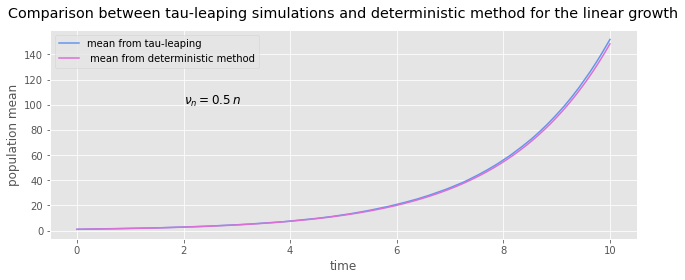

In [74]:
def tau_leaping(b, tau, P0, n_steps, n_sim):
    
    """
    b = birth_rate
    n_steps = number of steps
    P0 = initial population 
    n_sim = number of simulations
    d = degree of population growth. 
    """
    X2 = np.zeros((n_sim, n_steps))  # population matrix
    X2[:,0] = P0

    for j in range(n_sim):
        for i in range(n_steps-1):
            r = np.random.poisson(lam = b*X2[j,i]*tau)
            X2[j,i+1] = X2[j,i] + r
            
    X2_aver = np.mean(X2, axis=0)
                
    return [X2, X2_aver]  


def exact_mean(b, P0, t):
    
    y =  P0*np.exp(b*t)
    return y        

    
def tau_leaping_plots(b, tau, P0, n_steps, n_sim):
    
    fig, ax = plt.subplots(1,figsize=(10,4))
     
    col = ['cornflowerblue','orchid']
   
    [X2, X2_aver] = tau_leaping(b, tau, P0, n_steps, n_sim)
    t = np.linspace(0, tau*n_steps, n_steps)
    y = exact_mean(b, P0, t)
    ax.plot(t, X2_aver, color=col[0], label='tau_leaping')
    ax.plot(t, y, color=col[1], label='exact mean')
    ax.set_title('Comparison between tau-leaping simulations'\
                 ' and deterministic method for the linear growth', y=1.03) 
    ax.text(2,100, r"$\nu_n = 0.5\,n$", style = 'italic' , fontsize=12)
    ax.legend(['mean from tau-leaping',' mean from deterministic method'])
    ax.set_xlabel('time',fontsize=12)
    ax.set_ylabel('population mean',fontsize=12)  
    plt.tight_layout()
    
b = 0.5
tau = 0.01
P0 = 1 
n_steps = 1000
n_sim = 1000
  
tau_leaping_plots(b, tau, P0, n_steps, n_sim)    

 In the next cell, I have plotted kernel density estimation for $1000$ simulations of population size at time $10$.

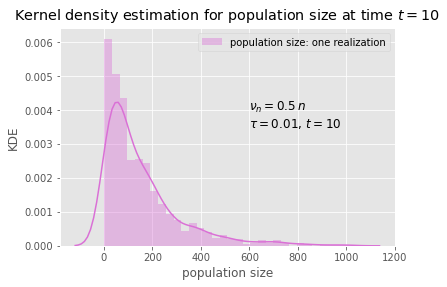

In [66]:
def tau_leaping_hist(b, tau, P0, n_steps, n_sim):
    
    fig, ax = plt.subplots()
   
    [X2, X2_aver] = tau_leaping(b, tau, P0, n_steps, n_sim)
    sns.distplot(X2[:,n_steps-1], label='tau_leaping', color='orchid')
    ax.legend(['population size: one realization'])
    ax.text(600,0.004, r"$\nu_n=0.5\,n$", style = 'italic' , size=12)
    ax.text(600,0.0035, r"$\tau=0.01,\,t =10$", style = 'italic' , size=12)
    ax.set_xlabel('population size',fontsize=12)
    ax.set_ylabel('KDE',fontsize=12)
    plt.title(r'Kernel density estimation for population size at time'\
                 r' $t=10$', va='center', ha='center',y=1.03) 
       
    
b = 0.5
tau = 0.01
P0 = 1 
n_steps = 1000
n_sim = 1000


tau_leaping_hist(b, tau, P0, n_steps, n_sim)

And different trajectories ( realizations ) for population size where $\nu_{n}=0.5\,n$.

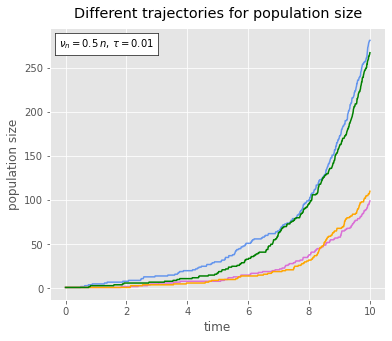

In [40]:

def trajectories(b, tau, P0, n_steps, n_sim):
    
    fig, ax = plt.subplots(figsize=(6,5))
    col = ['cornflowerblue','orchid','orange','green']
    [X2, X2_aver] = tau_leaping(b, tau, P0, n_steps, n_sim)
    t = np.linspace(0, tau*n_steps, n_steps)
    
    for i in range(n_sim):
        
        ax.plot(t,X2[i,:], color=col[i])
        at = AnchoredText(r'$\nu_n=0.5\,n,\,\tau=0.01$', loc='upper left', frameon=True)
        ax.add_artist(at)
        ax.set_xlabel('time',fontsize=12)
        ax.set_ylabel('population size',fontsize=12)
        plt.title(r'Different trajectories for population size', va='center', ha='center',y=1.03) 

    
b = 0.5
tau = 0.01
P0 = 1 
n_steps = 1000
n_sim = 4

trajectories(b, tau, P0, n_steps, n_sim)